In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [1]:
import scipy.stats as stats
import pymc as pm
import arviz as az

In [3]:
az.style.use('arviz-darkgrid')

## PyMC3 primer

In [4]:
np.random.seed(123)
trials = 4
θ_real = 0.35  # unknown value in a real experiment
data = stats.bernoulli.rvs(p=θ_real, size=trials)
data

array([1, 0, 0, 0])

In [5]:
with pm.Model() as model1:
    # a priori
    θ = pm.Beta('θ', alpha=1., beta=1.)
    # likelihood
    y = pm.Bernoulli('y', p=θ, observed=data)
    # trace = pm.sample(1000, random_seed=123, return_inferencedata=True)
    # trace.to_netcdf("data/ch3/coin_bern.nc")
    trace = az.from_netcdf("../../data-pymc/ch3/coin_bern.nc")

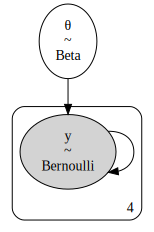

In [6]:
pm.model_to_graphviz(model1)

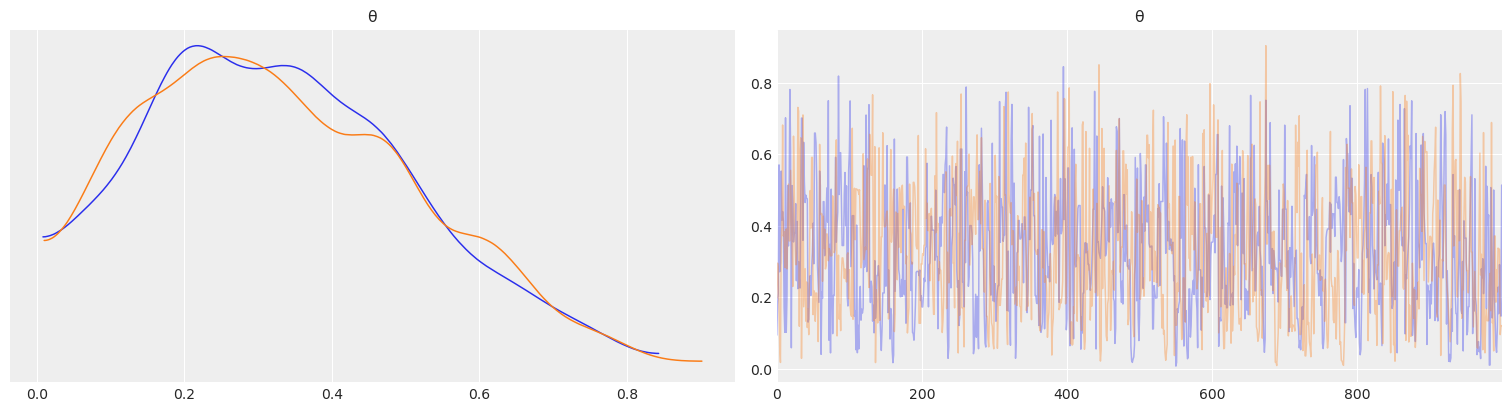

In [7]:
az.plot_trace(trace, figsize=(15, 4), compact=False);
# plt.savefig('images/ch3/bern_trace.png')

In [8]:
az.summary(trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
θ  0.331  0.178   0.035    0.659      0.006    0.005     740.0    1025.0   

   r_hat  
θ    1.0

In [9]:
# az.summary(trace).to_markdown()

### Highest density interval

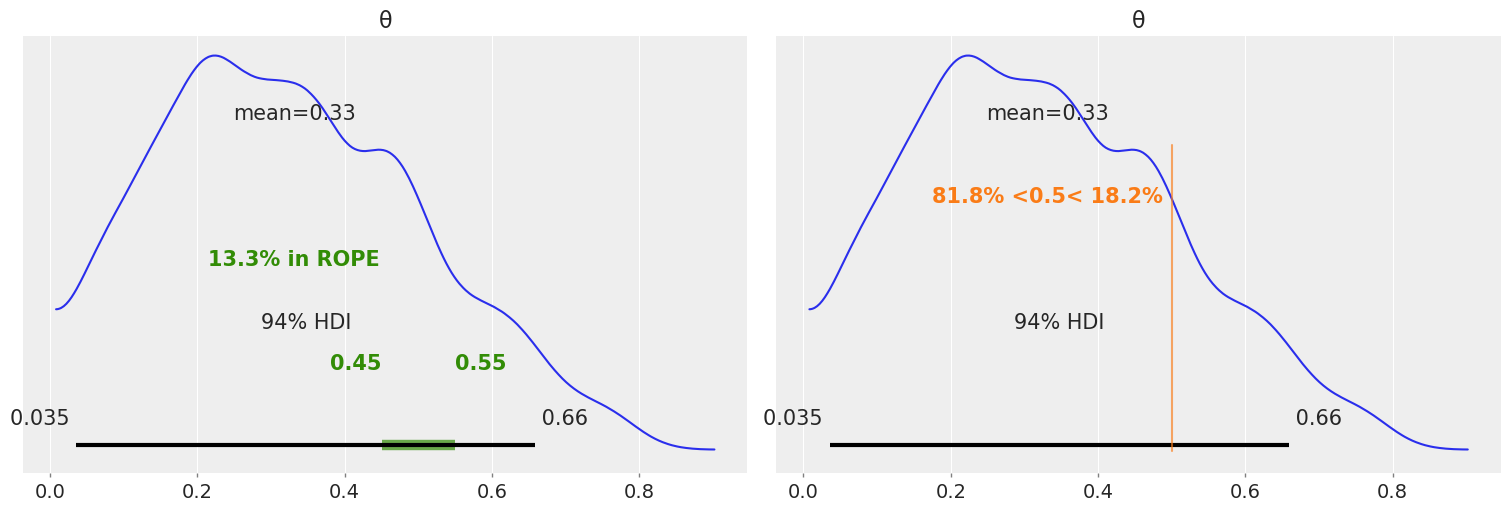

In [10]:
_, axes = plt.subplots(1, 2, figsize=(15, 5),  constrained_layout=True)

az.plot_posterior(trace, rope=[0.45, .55], ax=axes[0])
az.plot_posterior(trace, ref_val=0.5, ax=axes[1])
plt.show();
# plt.savefig('images/ch3/hdi.png')

In [11]:
with model1:
    y_pred = pm.sample_posterior_predictive(trace, 100, random_seed=123)
    ppc = az.from_pymc(posterior_predictive=y_pred)

IncorrectArgumentsError: Should not specify both keep_size and samples arguments. See the docstring of the samples argument for more details.

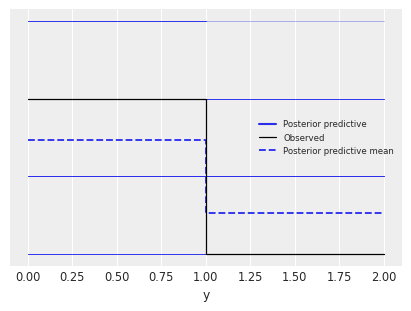

In [ ]:
az.plot_ppc(ppc, figsize=(4, 3), mean=True);
# plt.savefig('images/ch3/bern_ppc.png')

### Loss

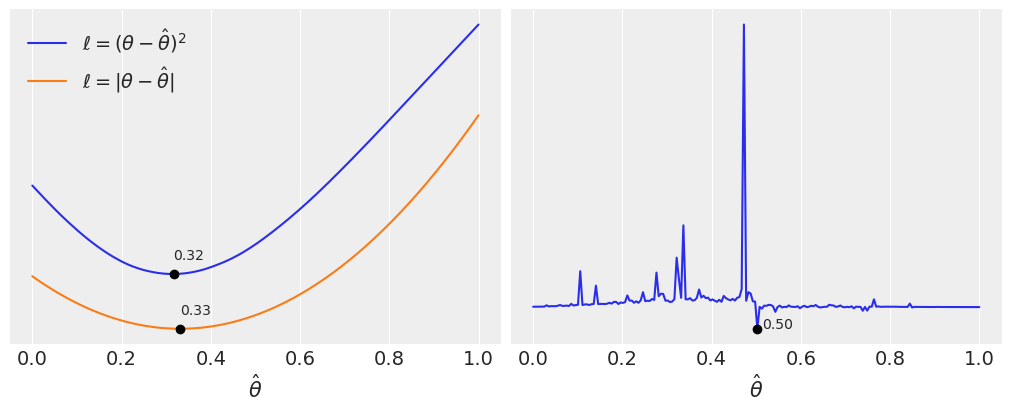

In [ ]:
grid = np.linspace(0, 1, 200)

θ_pos = trace.posterior['θ']
lossf_a = [np.mean(abs(i - θ_pos)) for i in grid]
lossf_b = [np.mean((i - θ_pos)**2) for i in grid]

_, axes = plt.subplots(1, 2, figsize=(10, 4),  constrained_layout=True)

labels = ('$ℓ = (θ - \hat{θ})^2$', '$ℓ = |θ - \hat{θ}|$')

for lossf, label in zip([lossf_a, lossf_b], labels):
    mini = np.argmin(lossf)
    axes[0].plot(grid, lossf, label=label)
    axes[0].plot(grid[mini], lossf[mini], 'ko')
    axes[0].annotate(f'{grid[mini]:.2f}', (grid[mini], lossf[mini] + 0.03))
    axes[0].set(xlabel='$\hat θ$', yticks=[])
    axes[0].legend()

lossf = []
for i in grid:
    if i < 0.5:
        f = np.mean(np.pi * θ_pos / np.abs(i - θ_pos))
    else:
        f = np.mean(1 / (i - θ_pos))
    lossf.append(f)

mini = np.argmin(lossf)
axes[1].plot(grid, lossf)
axes[1].plot(grid[mini], lossf[mini], 'ko')
axes[1].annotate(f'{grid[mini]:.2f}', (grid[mini] + 0.01, lossf[mini] + 0.1))
axes[1].set(xlabel='$\hat θ$', yticks=[])

# plt.savefig('images/ch3/loss.png')
plt.show()

In [ ]:
np.mean(θ_pos), np.median(θ_pos)

(<xarray.DataArray 'θ' ()>
 array(0.33148145),
 0.31532079680358993)

## Gaussian inferences

In [ ]:
shift = pd.read_csv('../../data-pymc/chemical_shifts.csv', header=None)
shift

0
0   51.06
1   55.12
2   53.73
3   50.24
4   52.05
5   56.40
6   48.45
7   52.34
8   55.65
9   51.49
10  51.86
11  63.43
12  53.00
13  56.09
14  51.93
15  52.31
16  52.33
17  57.48
18  57.44
19  55.14
20  53.93
21  54.62
22  56.09
23  68.58
24  51.36
25  55.47
26  50.73
27  51.94
28  54.95
29  50.39
30  52.91
31  51.50
32  52.68
33  47.72
34  49.73
35  51.82
36  54.99
37  52.84
38  53.19
39  54.52
40  51.46
41  53.73
42  51.61
43  49.81
44  52.42
45  54.30
46  53.84
47  53.16

/opt/homebrew/Caskroom/mambaforge/base/envs/kaggle/lib/python3.9/site-packages/arviz/stats/density_utils.py:480: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  if x.size == 0 or np.all(x == x[0]):
/opt/homebrew/Caskroom/mambaforge/base/envs/kaggle/lib/python3.9/site-packages/arviz/stats/density_utils.py:955: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "histogram" failed type inference due to: non-precise type pyobject
During: typing of argument at /opt/homebrew/Caskroom/mambaforge/base/envs/kaggle/lib/python3.9/site-packages/arviz/stats/density_utils.py (977)

File "../../../../../../opt/homebrew/Caskroom/mambaforge/base/envs/kaggle/lib/python3.9/site-packages/arviz/stats/density_utils.py", line 977:
def histogram(data, bins, range_hist=None):
    <source elide

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

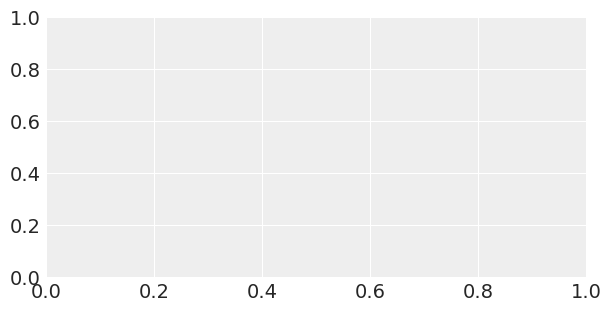

In [ ]:
_, axes = plt.subplots(figsize=(6, 3), dpi=100)

az.plot_kde(shift, rug=True)
# plt.savefig('images/ch3/gauss_kde.png')
plt.show();

### Sampling

In [ ]:
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=40, upper=70)
    σ = pm.HalfNormal('σ', sd=10)
    y = pm.Normal('y', mu=μ, sd=σ, observed=shift)
    # trace_g = pm.sample(1000, return_inferencedata=True)
    # trace_g.to_netcdf("data/ch3/chem_gauss.nc")
    trace_g = az.from_netcdf("../../data-pymc/ch3/chem_gauss.nc")

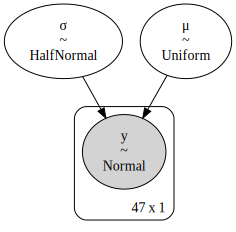

In [ ]:
pm.model_to_graphviz(model_g)

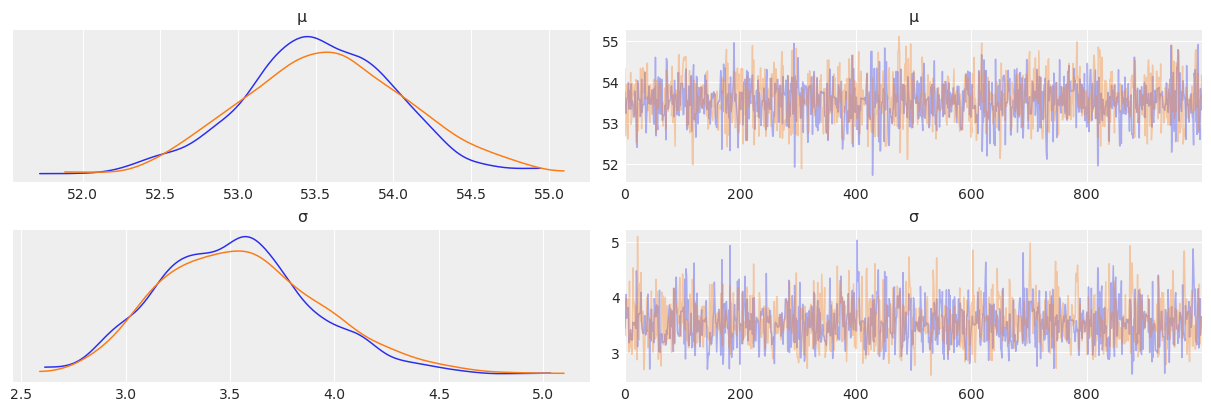

In [ ]:
az.plot_trace(trace_g, compact = False);
# plt.savefig('images/ch3/gauss_trace.png')

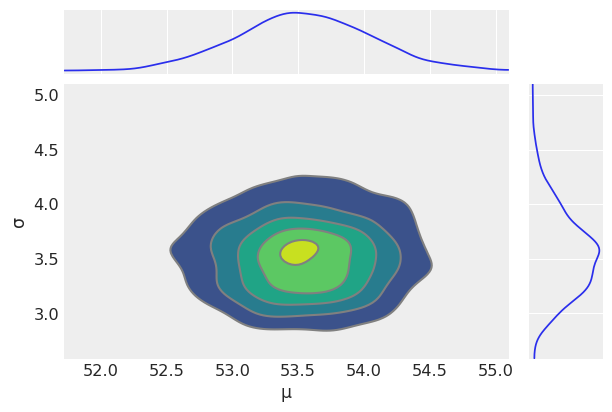

In [ ]:
az.plot_pair(trace_g,
             kind='kde',
             marginals=True,
             fill_last=False,
             figsize=(6, 4))

plt.show();
# plt.savefig('images/ch3/gauss_joint.png')

In [ ]:
az.summary(trace_g)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
μ  53.541  0.517  52.567   54.542      0.012    0.009    1730.0     985.0   
σ   3.548  0.386   2.832    4.239      0.010    0.007    1505.0    1334.0   

   r_hat  
μ    1.0  
σ    1.0

In [ ]:
# az.summary(trace_g).to_markdown()

### Posterior predictive checks

In [ ]:
with model_g:
    y_pred_g = pm.sample_posterior_predictive(trace_g, 100, random_seed=123)
    ppc_g = az.from_pymc3(posterior_predictive=y_pred_g)

/usr/local/Caskroom/miniconda/base/envs/kaggle/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


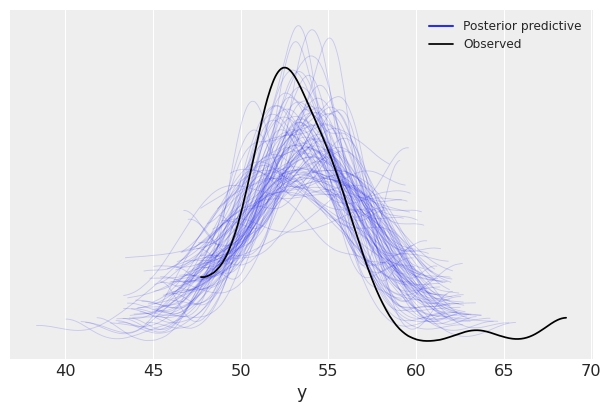

In [ ]:
az.plot_ppc(ppc_g, figsize=(6, 4), mean=False);
# plt.savefig('images/ch3/gauss_ppc.png')

## Robust inferences

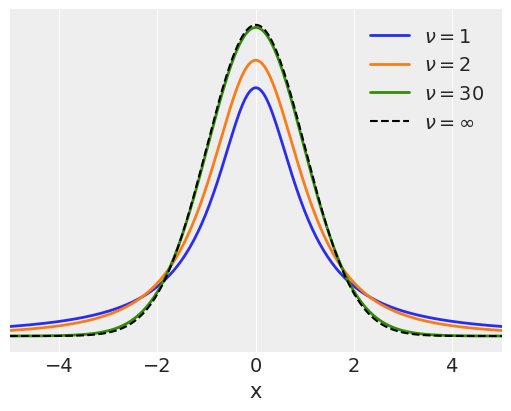

In [ ]:
_, ax = plt.subplots(figsize=(5, 4), dpi=100)

x_values = np.linspace(-10, 10, 500)

for df in [1, 2, 30]:
    distri = stats.t(df)
    x_pdf = distri.pdf(x_values)
    ax.plot(x_values, x_pdf, label=f'$ν = {df}$', lw=2)

x_pdf = stats.norm.pdf(x_values)

ax.plot(x_values, x_pdf, 'k--', label=r'$ν = ∞$')
ax.set(xlabel='x', yticks=[], xlim=(-5, 5))
ax.legend()
# plt.savefig('images/ch3/t_dist.png')

### Sampling

In [ ]:
with pm.Model() as model_t:
    μ = pm.Uniform('μ', 40, 75)
    σ = pm.HalfNormal('σ', sd=10)
    ν = pm.Exponential('ν', 1/30)
    y = pm.StudentT('y', mu=μ, sd=σ, nu=ν, observed=shift)
    # trace_t = pm.sample(1000, return_inferencedata=True)
    # trace_t.to_netcdf("data/ch3/chem_t.nc")
    trace_t = az.from_netcdf("../../data-pymc/ch3/chem_t.nc")

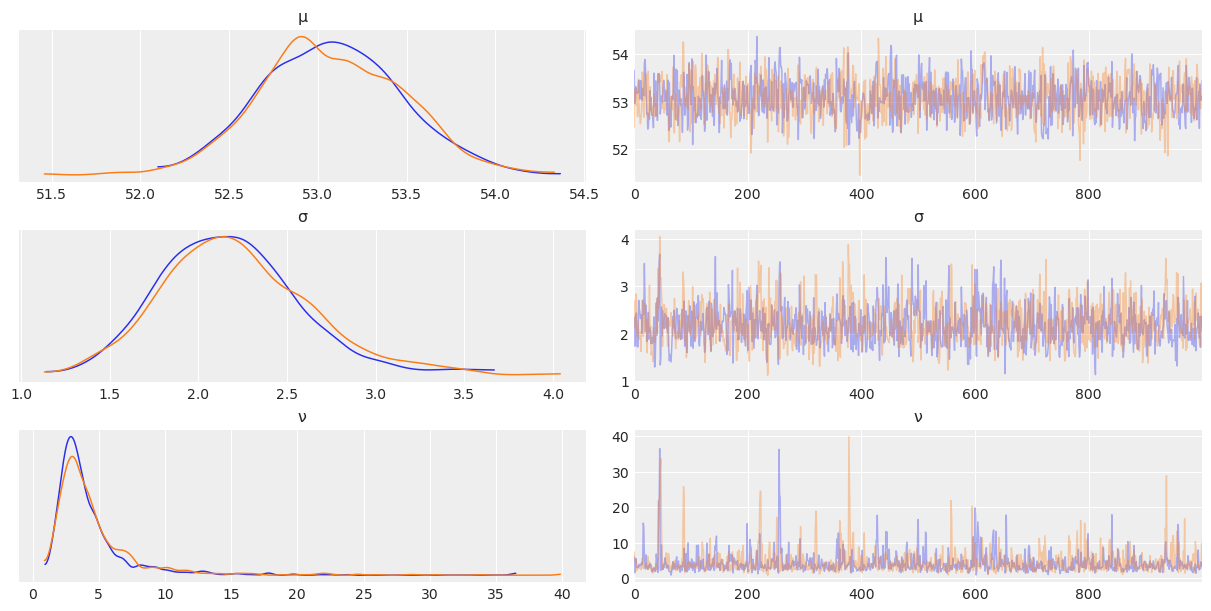

In [ ]:
az.plot_trace(trace_t, compact=False);
# plt.savefig('images/ch3/t_trace.png')

In [ ]:
az.summary(trace_t)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
μ  53.078  0.396  52.342   53.796      0.012    0.009    1040.0    1217.0   
σ   2.198  0.413   1.429    2.964      0.013    0.009    1084.0    1135.0   
ν   4.481  3.440   0.893    9.564      0.126    0.089    1071.0     934.0   

   r_hat  
μ    1.0  
σ    1.0  
ν    1.0

In [ ]:
# az.summary(trace_t).to_markdown()

In [ ]:
with model_t:
    y_ppc_t = pm.sample_posterior_predictive(trace_t, 100, random_seed=123)
    y_pred_t = az.from_pymc3(posterior_predictive=y_ppc_t)

/usr/local/Caskroom/miniconda/base/envs/kaggle/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


(40.0, 70.0)

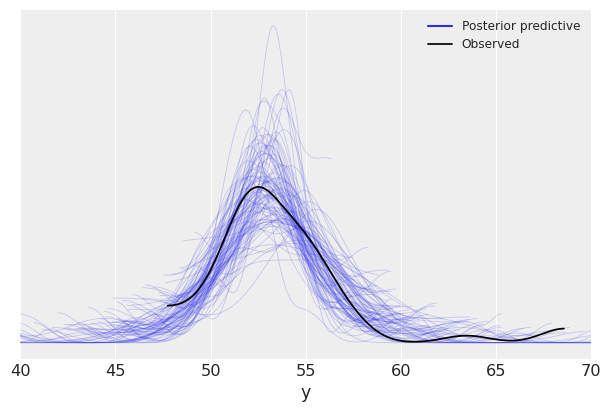

In [ ]:
az.plot_ppc(y_pred_t, figsize=(6, 4), mean=False)
plt.xlim(40, 70)
# plt.savefig('images/ch3/t_ppc.png')

# Tips example

In [ ]:
tips = sns.load_dataset('tips')
tips.head()

total_bill   tip     sex smoker  day    time  size
0       16.99  1.01  Female     No  Sun  Dinner     2
1       10.34  1.66    Male     No  Sun  Dinner     3
2       21.01  3.50    Male     No  Sun  Dinner     3
3       23.68  3.31    Male     No  Sun  Dinner     2
4       24.59  3.61  Female     No  Sun  Dinner     4

<AxesSubplot:xlabel='day', ylabel='tip'>

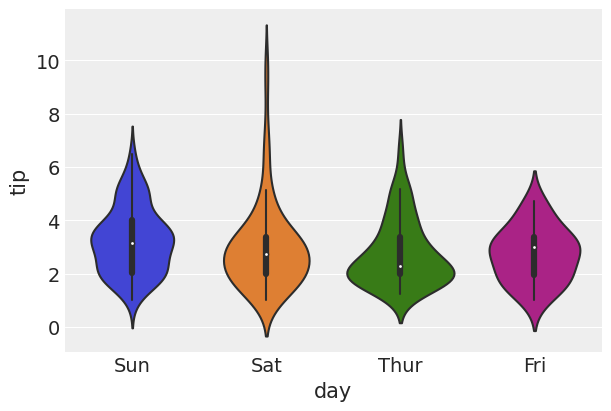

In [ ]:
_, ax = plt.subplots(figsize=(6, 4), dpi=100)

sns.violinplot(x='day', y='tip', data=tips, ax=ax)
# plt.savefig('images/ch3/tips_violin.png')

In [ ]:
tip = tips['tip'].values
idx = pd.Categorical(tips['day'],
                     categories=['Thur', 'Fri', 'Sat', 'Sun']).codes
groups = len(np.unique(idx))

### Sampling

In [ ]:
with pm.Model() as comparing_groups:
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=tip)

    # trace_cg = pm.sample(5000, return_inferencedata=True)
    # trace_cg.to_netcdf("data/ch3/tips_gauss.nc")
    trace_cg = az.from_netcdf("../../data-pymc/ch3/tips_gauss.nc")

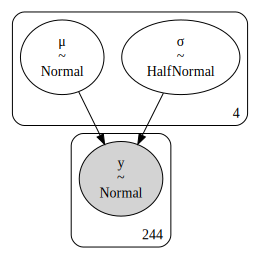

In [ ]:
pm.model_to_graphviz(comparing_groups)

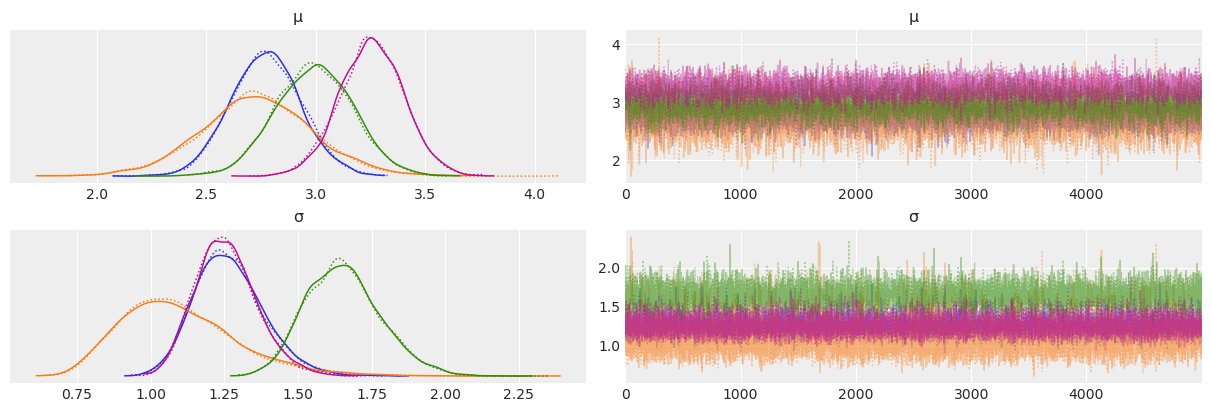

In [ ]:
az.plot_trace(trace_cg);

In [ ]:
from itertools import product, combinations

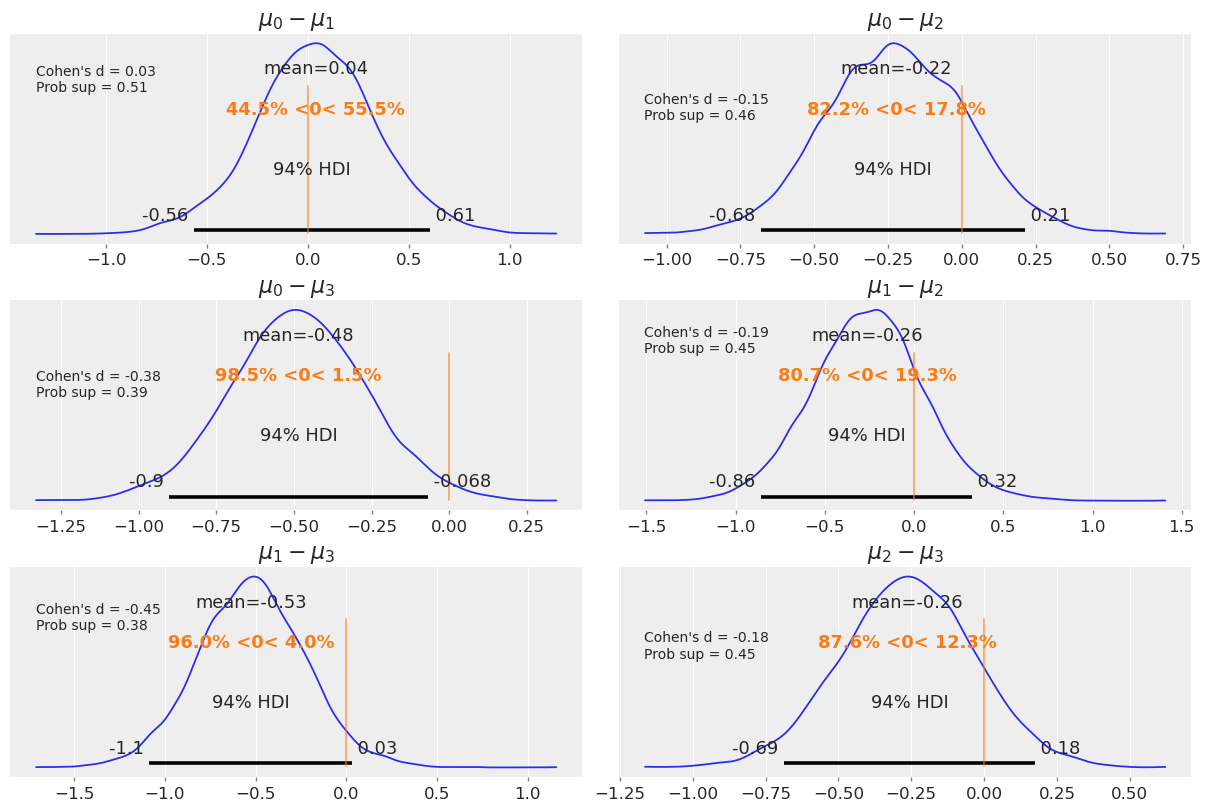

In [ ]:
_, axes = plt.subplots(3, 2, figsize=(12, 8), constrained_layout=True)

comparisons = combinations(range(4), 2)
pos = product(range(3), range(2))

dist = stats.norm()

for ind, ax in zip(comparisons, axes.flatten()):

    means_diff = trace_cg.posterior['μ'][:, :, ind[0]] - trace_cg.posterior[
        'μ'][:, :, ind[1]]
    var_diff = (trace_cg.posterior.σ[:, :, ind[0]]**2 +
                trace_cg.posterior.σ[:, :, ind[1]]**2) / 2

    d_cohen = (means_diff / np.sqrt(var_diff)).mean().values
    sup = dist.cdf(d_cohen / np.sqrt(2))

    az.plot_posterior(means_diff, ref_val=0, textsize=12, ax=ax)
    ax.set(title=f'$μ_{ind[0]}-μ_{ind[1]}$')
    ax.text(means_diff.min(),
            1,
            s=f"Cohen's d = {d_cohen:.2f}\nProb sup = {sup:.2f}")

# plt.savefig('images/ch3/tips_diff.png')
plt.show()

# Hierarchical Models

In [ ]:
N_samples = [30, 30, 30]
G_samples = [18, 18, 18]

group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
group_idx

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

In [ ]:
with pm.Model() as model_h:
    μ = pm.Beta('μ', 1., 1.)
    κ = pm.HalfNormal('κ', 10)

    θ = pm.Beta('θ', alpha=μ * κ, beta=(1.0 - μ) * κ, shape=len(N_samples))
    y = pm.Bernoulli('y', p=θ[group_idx], observed=data)

    # trace_h = pm.sample(2000, return_inferencedata=True)
    # trace_h.to_netcdf("data/ch3/coin_h.nc")
    trace_h = az.from_netcdf("../../data-pymc/ch3/coin_h.nc")

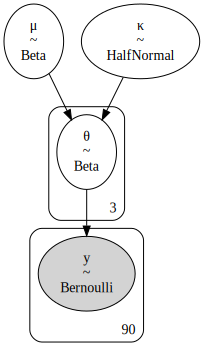

In [ ]:
pm.model_to_graphviz(model_h)

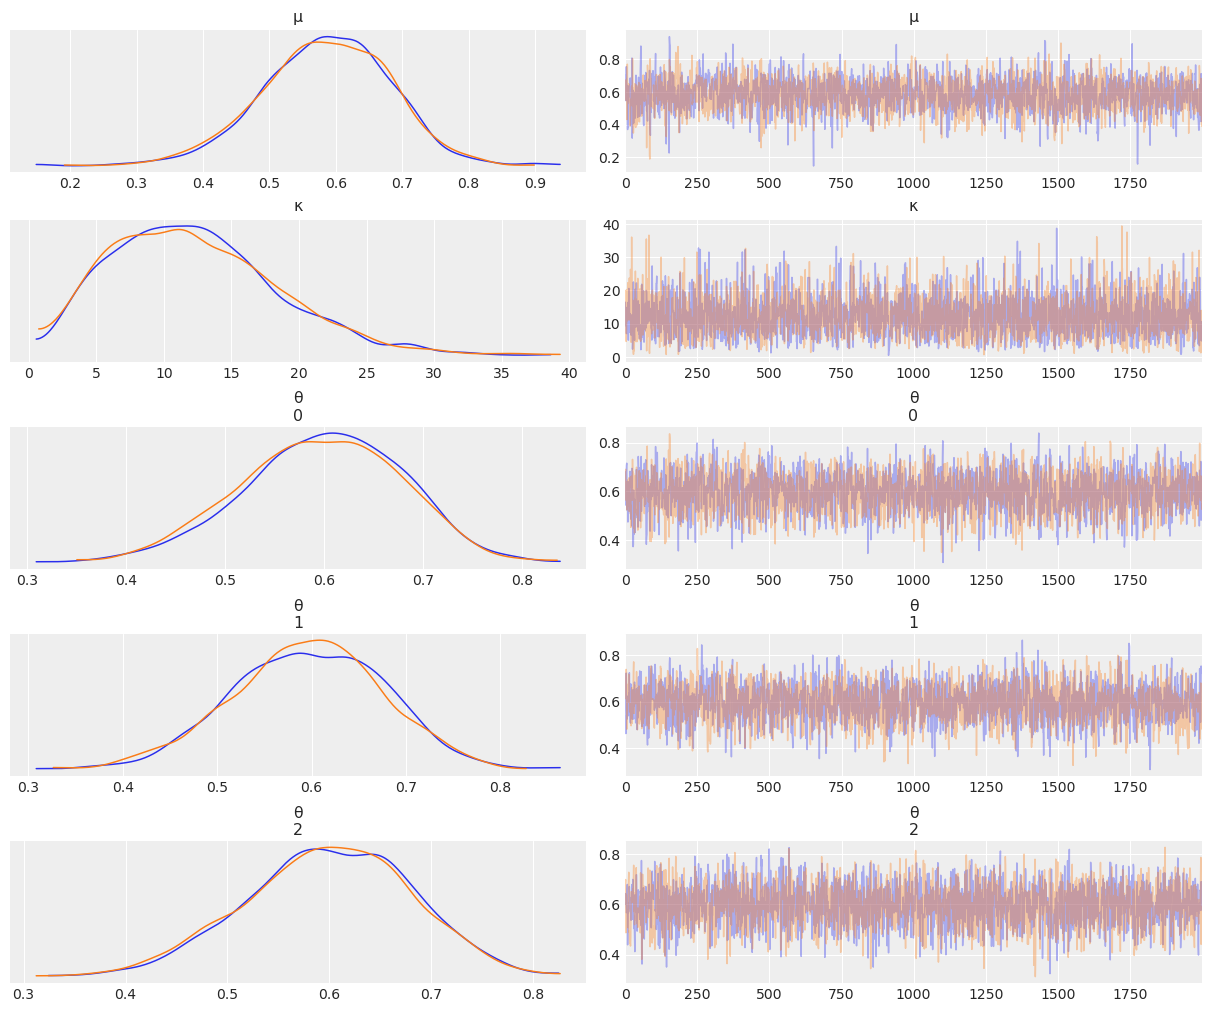

In [ ]:
az.plot_trace(trace_h, compact=False);

In [ ]:
az.summary(trace_h)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
μ      0.585  0.098   0.394    0.755      0.002    0.001    2464.0    2182.0   
κ     12.283  6.141   2.522   23.913      0.111    0.078    2800.0    2464.0   
θ[0]   0.598  0.080   0.447    0.739      0.001    0.001    2811.0    2524.0   
θ[1]   0.595  0.080   0.441    0.736      0.002    0.001    2486.0    2507.0   
θ[2]   0.599  0.081   0.456    0.756      0.001    0.001    3130.0    2963.0   

      r_hat  
μ       1.0  
κ       1.0  
θ[0]    1.0  
θ[1]    1.0  
θ[2]    1.0

In [ ]:
trace_h.posterior['μ'].shape

(2, 2000)

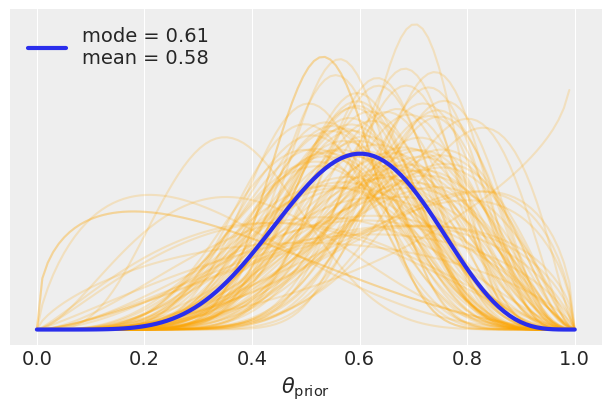

In [ ]:
x = np.linspace(0, 1, 100)

_, ax = plt.subplots(figsize=(6, 4), dpi=100)

for i in np.random.randint(0, 2000, size=100):
    u = trace_h.posterior['μ'][0, i]
    k = trace_h.posterior['κ'][0, i]
    pdf = stats.beta(u * k, (1.0 - u) * k).pdf(x)
    ax.plot(x, pdf, 'orange', alpha=0.2)

μ_mean = trace_h.posterior['μ'].mean()
κ_mean = trace_h.posterior['κ'].mean()

dist = stats.beta(μ_mean * κ_mean, (1.0 - μ_mean) * κ_mean)
pdf = dist.pdf(x)
mode = x[np.argmax(pdf)]
mean = dist.moment(1)

ax.plot(x, pdf, lw=3, label=f'mode = {mode:.2f}\nmean = {mean.values:.2f}')
ax.set(xlabel='$θ_{\mathrm{prior}}$', yticks=[])
ax.legend()
# plt.savefig('images/ch3/h_model.png')
plt.show()

In [ ]:
cs_data = pd.read_csv('data/chemical_shifts_theo_exp.csv')
cs_data.head()

ID   aa   theo    exp
0  1BM8  ILE  61.18  58.27
1  1BM8  TYR  56.95  56.18
2  1BM8  SER  56.35  56.84
3  1BM8  ALA  51.96  51.01
4  1BM8  ARG  56.54  54.64

In [ ]:
diff = cs_data.theo.values - cs_data.exp.values
idx = pd.Categorical(cs_data['aa']).codes
groups = len(np.unique(idx))
groups

19

In [ ]:
with pm.Model() as cs:
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=diff)

    # trace_cs = pm.sample(1000, return_inferencedata=True)
    # trace_cs.to_netcdf("data/ch3/chem_nh.nc")
    trace_cs = az.from_netcdf("../../data-pymc/ch3/chem_nh.nc")

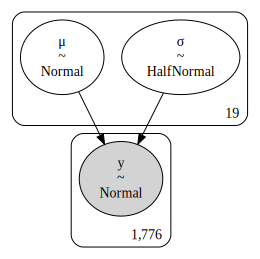

In [ ]:
pm.model_to_graphviz(cs)

In [ ]:
with pm.Model() as cs_h:
    # hyper_priors
    μ_μ = pm.Normal('μ_μ', mu=0, sd=10)
    σ_μ = pm.HalfNormal('σ_μ', 10)

    # priors
    μ = pm.Normal('μ', mu=μ_μ, sd=σ_μ, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=diff)

    # trace_cs_h = pm.sample(1000, return_inferencedata=True)
    # trace_cs_h.to_netcdf("data/ch3/chem_h.nc")
    trace_cs_h = az.from_netcdf("../../data-pymc/ch3/chem_h.nc")

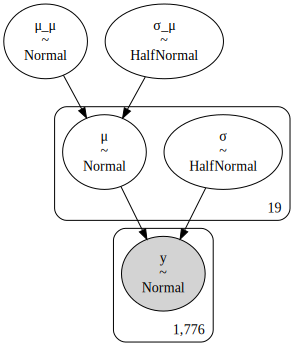

In [ ]:
pm.model_to_graphviz(cs_h)

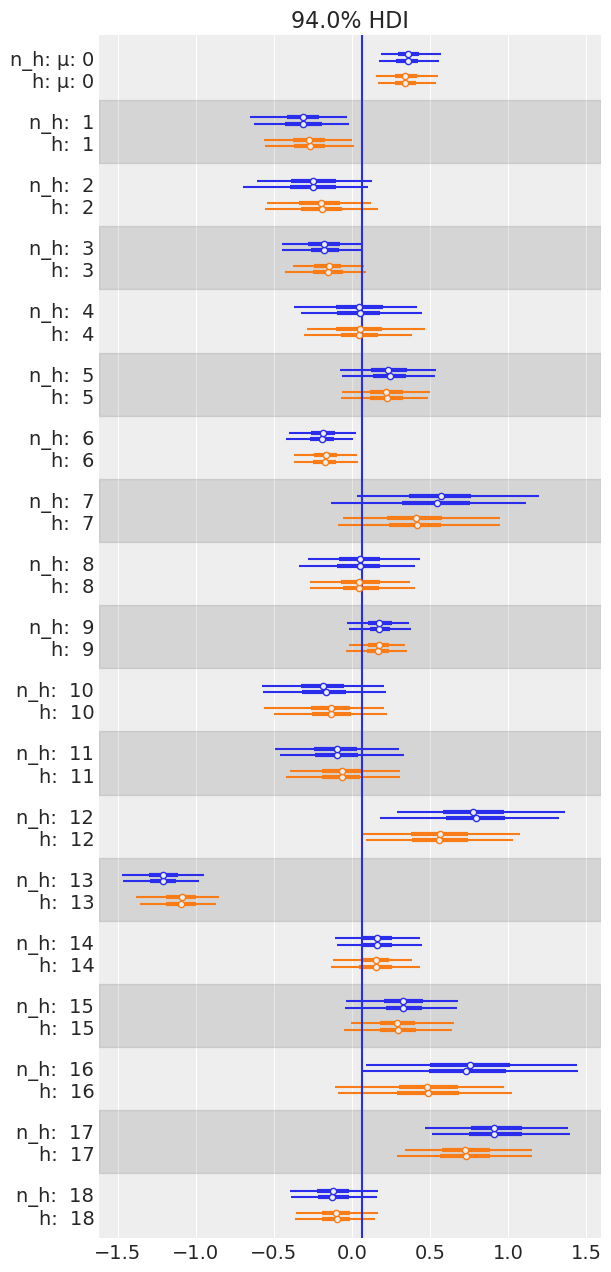

In [ ]:
ax = az.plot_forest(data=[trace_cs, trace_cs_h],
                         model_names=['n_h', 'h'],
                         var_names=['μ'],
                         combined=False,
                         colors='cycle')

y_lims = ax[0].get_ylim()
ax[0].vlines(trace_cs_h.posterior['μ_μ'].mean(), *y_lims)
# plt.savefig('images/ch3/h_comparison.png')
plt.show()